In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.1.3.


# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

#### Описание данных

Признаки:

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевой признак:

* Price — цена (евро)

## Подготовка данных

In [2]:
pip install catboost

In [3]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [4]:
import re
import time
import warnings


import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor
from numpy.random import RandomState
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
warnings.filterwarnings('ignore')

RANDOM_STATE = 28

In [5]:
try:
    df = pd.read_csv('C:/Users/User/Downloads/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [9]:
df.duplicated().sum()

4

Названия стобцов приведем к `snake_case`.

Есть пропуски в столбцах : `VehicleType, Gearbox, Model, FuelType, Repaired`
Вероятно эти пропуски допустили сами пользователи при добавлении объявления на сайт. Многие могут не знать тип кузова автомобиля или тип топлива, ремонтировался автомобиль или нет потому что приобретался уже с пробегом. Так же тип трансмиссии могли не указывать люди которые знают что у них вариатор и назвать его автоматом не правильно по их мнению. 

Отметим бесполезные(которые не влияют на цену(не должны влиять)) стобцы для нашей задачи которые удалим: `DateCrawled, NumberOfPictures, PostalCode, LastSeen,` также столбцы `RegistrationYear, RegistrationMonth и DateCreated` только после того как вычислим возраст автомобиля.

Имеютя некорректные значения: цена = 0, год регистрации = 1000 или 9999, мощность = 0 или 20000, месяц регистрации = 0. Эти значения тоже могли добавить в таком виде пользователи либо извлечение данных из базы прошло не очень удачно.


Удалим явные дубликаты:

In [10]:
df = df.drop_duplicates().reset_index(drop=True)

Приведем названия столбцов к нормальному виду:

In [11]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

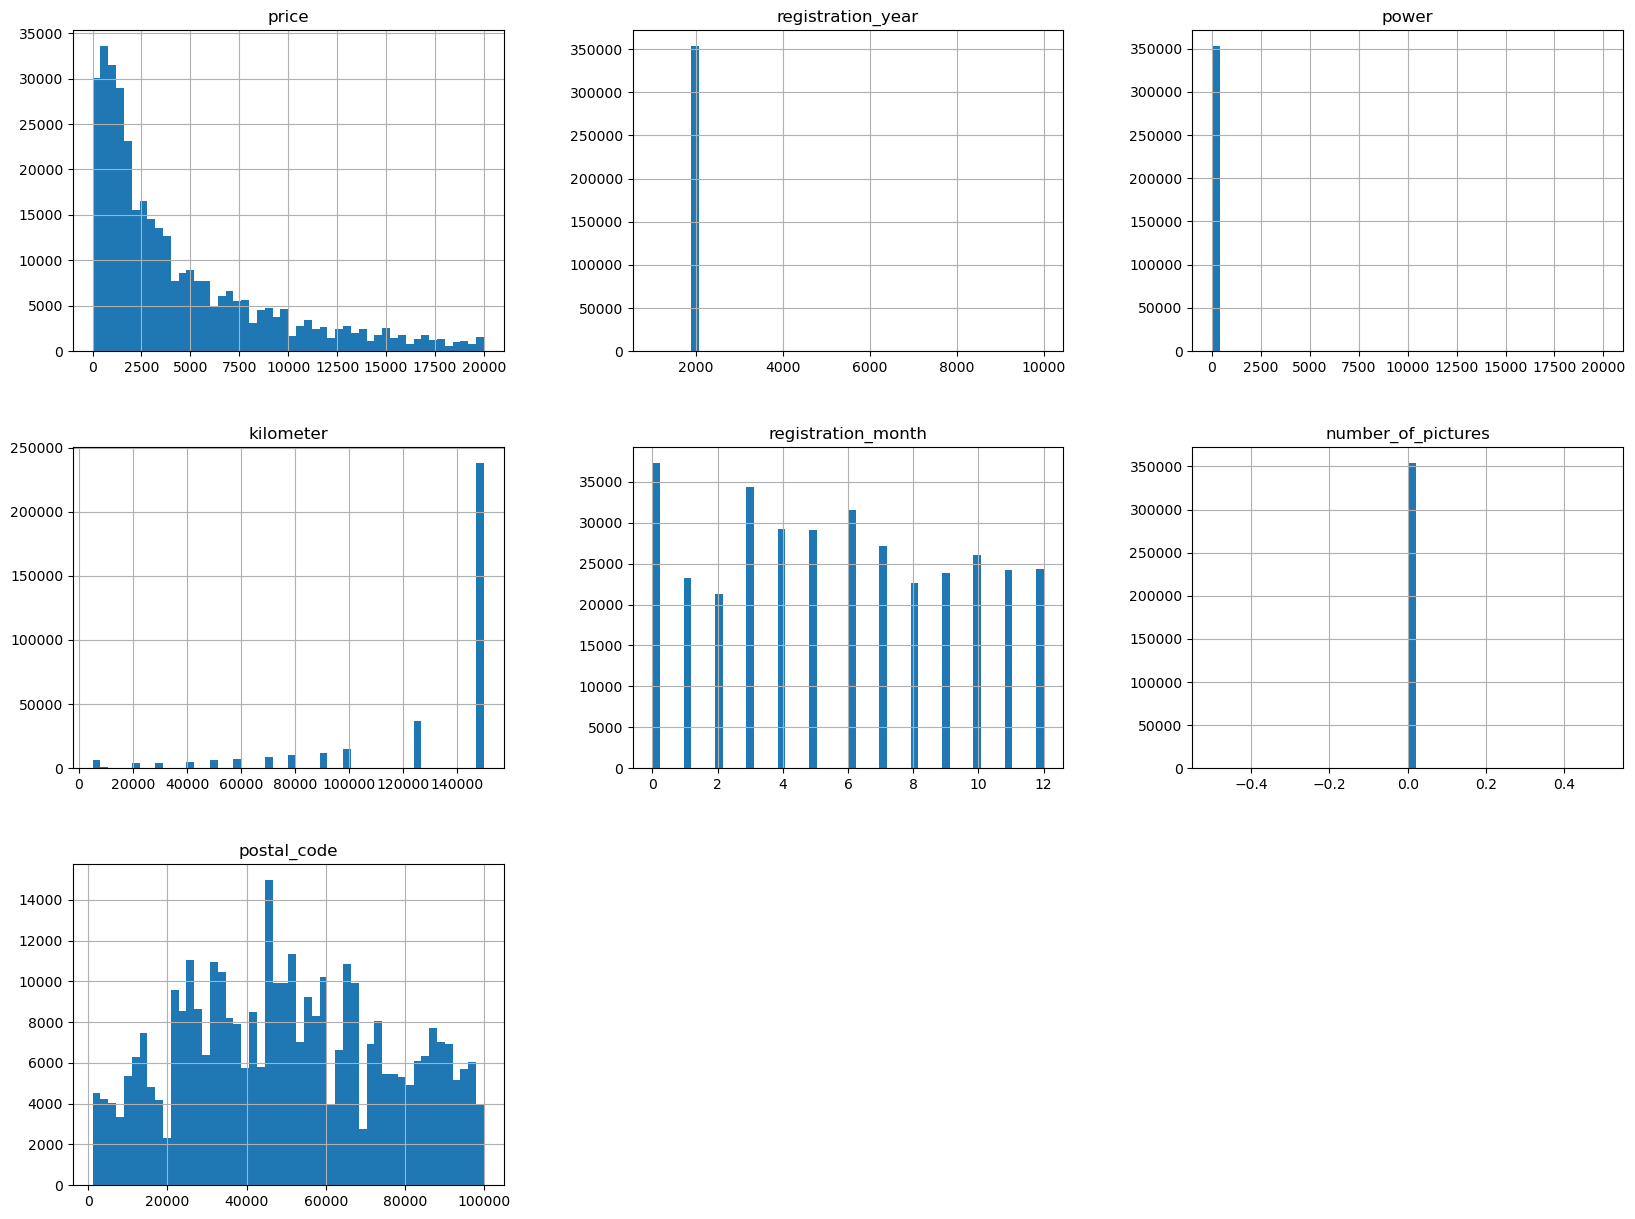

In [12]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Отфильтруем значения которые точно не соответствуют истине:

In [13]:
df = df.query('1950 < registration_year < 2023 and 5 < power < 5000 and 0 < registration_month')

In [14]:
lower_threshold = df['price'].quantile(0.02)
upper_threshold = df['price'].quantile(0.98)

df = df[(df['price'] >= lower_threshold) & (df['price'] <= upper_threshold)]
df['price'].describe()

count    280173.000000
mean       4701.061416
std        4209.996848
min          99.000000
25%        1400.000000
50%        3200.000000
75%        6900.000000
max       17800.000000
Name: price, dtype: float64

Рассчитаем в новом столбце `age` возраст автомобиля в годах:

In [15]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%dT%H:%M:%S')
df['registration'] = pd.to_datetime(df[['registration_month', 'registration_year']].astype(str).add(' ').sum(1))
df['age'] = ((df['last_seen'] - df['registration']).dt.days) / 365

Удалим ненужные столбцы:

In [16]:
df = df.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen', 'registration'], axis=1)

Заполним пропуски значением `unknown`:

In [17]:
columns_na = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']
df[columns_na] = df[columns_na].fillna('unknown')

In [18]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280173 entries, 2 to 354364
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         280173 non-null  int64  
 1   vehicle_type  280173 non-null  object 
 2   gearbox       280173 non-null  object 
 3   power         280173 non-null  int64  
 4   model         280173 non-null  object 
 5   kilometer     280173 non-null  int64  
 6   fuel_type     280173 non-null  object 
 7   brand         280173 non-null  object 
 8   repaired      280173 non-null  object 
 9   age           280173 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 23.5+ MB


,price,power,kilometer,age
count,280173.000000,280173.000000,280173.000000,280173.000000
mean,4701.061416,120.738683,128847.372873,12.513131
std,4209.996848,68.360039,36012.415299,6.681944
min,99.000000,6.000000,5000.000000,-3.668493
25%,1400.000000,75.000000,125000.000000,8.279452
50%,3200.000000,110.000000,150000.000000,12.413699
75%,6900.000000,149.000000,150000.000000,16.580822
max,17800.000000,4700.000000,150000.000000,65.306849


Почти все хорошо. Отрицательные значения в возрасте автомобиля. Может быть данные изначально кривые и месяц, год регистрации это про пользователя. 

Отфильтруем отрицательные значения:

In [19]:
df = df.query('0 < age')
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268453 entries, 2 to 354364
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         268453 non-null  int64  
 1   vehicle_type  268453 non-null  object 
 2   gearbox       268453 non-null  object 
 3   power         268453 non-null  int64  
 4   model         268453 non-null  object 
 5   kilometer     268453 non-null  int64  
 6   fuel_type     268453 non-null  object 
 7   brand         268453 non-null  object 
 8   repaired      268453 non-null  object 
 9   age           268453 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 22.5+ MB


Избавились от ~23% сомнительных признаков.

----------------------------

Предобработку начали с оформления - привели к snake_case названия столбцов. Далее удалили дубликаты и отфильтровали явные выбросы. Вычислили возраст автомобиля путем расчета времени между датой публикации объявления и датой регистрации автомобиля. Но из-за некорректности данных получились отрицательные значения возраста которые мы тоже отфильтровали.

## Обучение моделей

Кодируем категориальные признаки, определяем признаки и делим выборку на тренировочную и тестовую:

In [20]:
features = df.drop(['price'], axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=RANDOM_STATE
)

In [21]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()
print(cat_features)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']


In [22]:
ohe_features_rf = cat_features.copy()
ohe_features_rf.remove('model')
ohe_features_rf

['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']

In [23]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()

num_features

['power', 'kilometer', 'age']

In [24]:
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

#### RandomForest

In [25]:
%%time
col_transformer_rf= make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'), 
        ohe_features_rf
    ),
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
        ['model']
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough'
)

model_rf = RandomForestRegressor(random_state=RANDOM_STATE)

pipline_rf = make_pipeline(col_transformer_rf, model_rf)

param_grid_rf = {
    'randomforestregressor__n_estimators': [14],
    'randomforestregressor__max_depth': [5]
}

gs_rf = RandomizedSearchCV(
    pipline_rf, 
    param_distributions=param_grid_rf, 
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

gs_rf.fit(X_train_rf, y_train)

gs_rf_best_score = gs_rf.best_score_ * -1
gs_rf_best_params = gs_rf.best_params_
#print(f'best_score: {gs_rf_best_score}')
print(f'best_params: {gs_rf_best_params}')

results = gs_rf.cv_results_
best_index = gs_rf.best_index_

fit_time = results['mean_fit_time']
score_time = results['mean_score_time']
RMSE = gs_rf.best_score_ * -1

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

best_params: {'randomforestregressor__n_estimators': 14, 'randomforestregressor__max_depth': 5}
Fit time: [17.02050452], Predict time: [0.28436666], Best RMSE: 2189.627484052463
Wall time: 48.3 s


#### CatBoost

In [26]:
for X in cat_features:
    encoder = LabelEncoder()
    X_train[X] = encoder.fit_transform(X_train[X])
    X_test[X] = encoder.transform(X_test[X])

In [27]:
%%time
model = CatBoostRegressor()
param_grid = {
    'iterations': [30],
    'learning_rate': [0.3],
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5, scoring='neg_root_mean_squared_error',
    error_score='raise',
    n_jobs=-1,
)
grid_search.fit(X_train, y_train)

best_params_cbr = grid_search.best_params_
print(f'best_params: {best_params_cbr}')

results = grid_search.cv_results_
best_index = grid_search.best_index_

fit_time = results['mean_fit_time']
score_time = results['mean_score_time']
RMSE = grid_search.best_score_ * -1

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

0:	learn: 3419.9349101	total: 196ms	remaining: 5.67s
1:	learn: 2919.0466728	total: 230ms	remaining: 3.23s
2:	learn: 2580.0161188	total: 265ms	remaining: 2.39s
3:	learn: 2361.4816467	total: 299ms	remaining: 1.94s
4:	learn: 2217.1878142	total: 333ms	remaining: 1.66s
5:	learn: 2105.6603564	total: 366ms	remaining: 1.46s
6:	learn: 2041.4399122	total: 404ms	remaining: 1.33s
7:	learn: 1988.9903243	total: 444ms	remaining: 1.22s
8:	learn: 1945.9399301	total: 478ms	remaining: 1.11s
9:	learn: 1917.8923687	total: 509ms	remaining: 1.02s
10:	learn: 1897.4718831	total: 539ms	remaining: 932ms
11:	learn: 1859.6459678	total: 575ms	remaining: 862ms
12:	learn: 1844.5886033	total: 605ms	remaining: 791ms
13:	learn: 1815.4595032	total: 649ms	remaining: 742ms
14:	learn: 1800.2012526	total: 682ms	remaining: 682ms
15:	learn: 1788.2115053	total: 713ms	remaining: 624ms
16:	learn: 1780.2130683	total: 741ms	remaining: 567ms
17:	learn: 1771.2594801	total: 769ms	remaining: 513ms
18:	learn: 1763.8810098	total: 801ms	r

#### LightGBM

In [28]:
%%time
model = lgbm.LGBMRegressor()
param_grid = {
    'learning_rate': [0.3],
    'n_estimators': [150]
}

grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
)

grid_search.fit(X_train, y_train, categorical_feature=cat_features)

best_params = grid_search.best_params_
best_params_lgbm = grid_search.best_params_
print(f'best_params: {best_params_lgbm}')

results = grid_search.cv_results_
best_index = grid_search.best_index_

fit_time = results['mean_fit_time']
score_time = results['mean_score_time']
RMSE = grid_search.best_score_ * -1

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

best_params: {'learning_rate': 0.3, 'n_estimators': 150}
Fit time: [4.19626927], Predict time: [0.84997439], Best RMSE: 1449.518582222146
Wall time: 12.9 s


## Анализ моделей

Качество предсказания: RandomForest 2189,   CatBoost  1694 и lightGBM 1449

Время обучения:        RandomForest 16,     CatBoost  2.92 и lightGBM 4.32

Время предсказания:    RandomForest 0.29,   CatBoost  0.02 и lightGBM 0.9

Показатели времени LightGBM не лучшие но качество перевешивет. Проверим ее на тестовой выборке:

In [29]:
%%time

model = lgbm.LGBMRegressor(**grid_search.best_params_)
model.fit(X_train, y_train)

Wall time: 1.62 s


LGBMRegressor(learning_rate=0.3, n_estimators=150)

In [30]:
%%time
y_pred = grid_search.predict(X_test)

Wall time: 244 ms


In [31]:
print('RMSE:', mean_squared_error(y_test, y_pred)**0.5)

RMSE: 1445.3646378818273


Лучшая модель по скорости и качеству - LightGBM. При минимальном подборе гиперпараметров RMSE: 1445.

Качество всех рассмотренных моделей удовлетворяет требованиям. Потенциал по улучшению есть но решено не тратить время в ожидании подбора параметров.


